# Predict House Prices
Data has 79 explanatory variables describing aspects of residential homes in Ames, Iowa which can be downloaded [here](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/). Prediction modeling resulted in the following starting with the best:
* Decision tree r-squared is 0.9276 when using the best max tree.
* Gradient booster classification had the highest accuracy of 0.899 with a deviation of 0.031. 
* Random forest also had a very high r-squared value at  0.8905. 
* Linear regression produced only a 0.8002 result and 0.77850 for both lasso and ridge.
At the very end, a dollar price prediction will be made for all of the 1460 homes by analysis of the train dataset.
---------------
### View data
To view what the data looks like, the columns with the first five rows will be shown below.

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate
from statistics import mean
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.datasets import make_classification
from sklearn import ensemble
import warnings
warnings.filterwarnings('ignore')
 
train=r'C:\Users\sschm\Desktop\Kaggle\HousePrice\train.csv'#kaggleTrain=r'/kaggle/input/house-prices-advanced-regression-techniques/train.csv 
test=r'C:\Users\sschm\Desktop\Kaggle\HousePrice\test.csv' #kaggleTest=r"/kaggle/input/house-prices-advanced-regression-techniques/test.csv"'

data=pd.read_csv(train)  #(1459, 80) 
test=pd.read_csv(test)
print(data.head())

   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD   

### Find Missing Values
First, missing data needs to be checked. Too many missing data points will get a colulmn removed. An initial DataFrame with numeric values is analyzed. Later on, some catergorical values will be assigned a numeric value to analyze for better results. Deleting rows would be a bad idea since we need all rows to predict every house price. Therefore, amy column with lots of missing data will be removed. If a column has high feature importance, filling in the missing data with the mean can be considered.

In [2]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df = data.select_dtypes(include=numerics)

#search for columns with missing values:
def findNA():
    print("Missing data by column as a percent:")
    findNA=df.isnull().sum().sort_values(ascending=False)/len(data)
    print(findNA.head(4))
findNA() 

Missing data by column as a percent:
LotFrontage    0.177397
GarageYrBlt    0.055479
MasVnrArea     0.005479
Id             0.000000
dtype: float64


### Feature Engineering
For now, only numberic categorical values will be analyzed. Certain columns must be combined into one. For example, total square feet is a new column combined from three other columns. Since every house needs a dollar prediction price, one must not delete any rows. Therefore, any missing data will be filled in the mean. 

In [3]:
df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF'].drop(columns=['TotalBsmtSF', '1stFlrSF', '2ndFlrSF'])
#df["LotFrontage"] = df.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

df = df[df.isnull().sum(axis=1) <= 10] #remove col with 5 or more missing values
df= df.fillna(df.mean())

#SPLIT DATA:
X=df.drop('SalePrice', axis=1)
y=df['SalePrice']

# Correlations and Multicollinearity
Using a visual heatmap can display all correlations between features and detect multicollinearity. No major multicollinearity was detected other than first floor and basement floor with a .82 correlation. The square feet features were all combined into total square feet of the entire house. Variance inflation factor can also be calculated by calling the Python function by removing the comment on bottom.

AxesSubplot(0.125,0.125;0.62x0.755)
Highly correlated variables above:  0.8


,Correlation
GarageCars and GarageArea,0.882475
YearBuilt and GarageYrBlt,0.825667
GrLivArea and TotRmsAbvGrd,0.825489
TotalBsmtSF and 1stFlrSF,0.819530


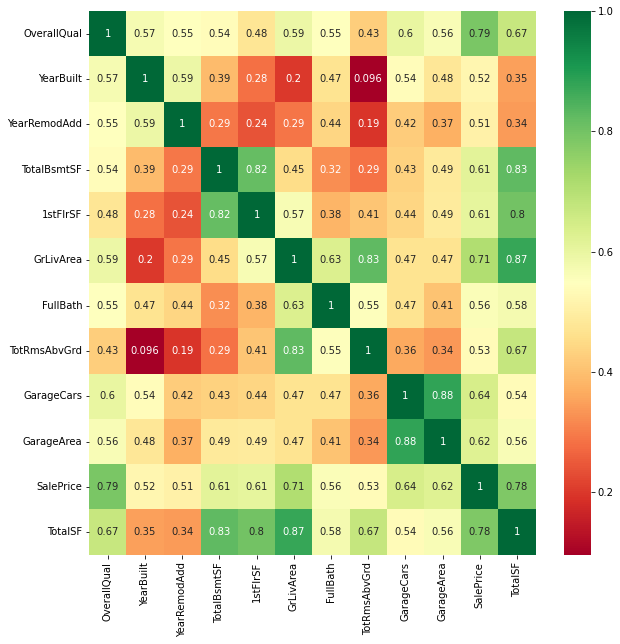

In [4]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def calc_VIF(x):
    vif= pd.DataFrame()
    vif['variables']=x.columns
    vif["VIF"]=[variance_inflation_factor(x.values,i) for i in range(x.shape[1])]
    return(vif)

#Find Multicollinearity using heat map:
def printHeat():
    corr = df.corr()
    #print(corr)
    highly_corr_features = corr.index[abs(corr["SalePrice"])>0.5]
    plt.figure(figsize=(10,10))
    heat = sns.heatmap(df[highly_corr_features].corr(),annot=True,cmap="RdYlGn")
    top10=corr["SalePrice"].sort_values(ascending=False).head(10)
    print(heat)
    #print(top10) # top ten correlations

#print correlation between features
def printHighCorr(df, features, threshold=0.8):
    print("Highly correlated variables above: ", threshold)
    corr_df = df[features].corr() # get correlations
    correlated_features = np.where(np.abs(corr_df) > threshold) # select ones above the abs threshold
    correlated_features = [(corr_df.iloc[x,y], x, y) for x, y in zip(*correlated_features) if x != y and x < y] # avoid duplication
    s_corr_list = sorted(correlated_features, key=lambda x: -abs(x[0])) # sort by correlation value
    correlation_df={}
    if s_corr_list == []:
        print("There are no highly correlated features with correlation above", threshold)
    else:
        for v, i, j in s_corr_list:
            correlation_df[corr_df.index[i] +" and "+ corr_df.columns[j]]= v
        correlation_df=pd.DataFrame(correlation_df,index=['Correlation'])
    return  correlation_df.T.sort_values(by='Correlation',ascending=False)

#Turn three functions on or off below:
printHeat() 
printHighCorr(data,data.columns).style.set_properties(**{'background-color': 'black','color': 'white'})

#calc_VIF(df[::-1]) #test for multicollinearity using VIF

#  Scatterplot Data
The most important features that were found with the highest correlation to house sales price which were the following: 'OverallQual','TotalBsmtSF','MSSubClass', 'LotArea'. This helps visually see the extent of correlations between the quantities and variables.

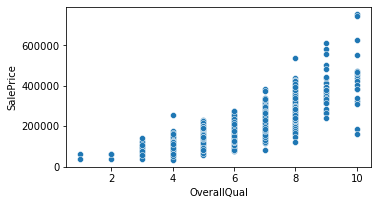

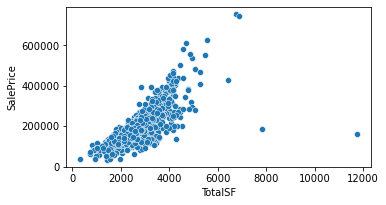

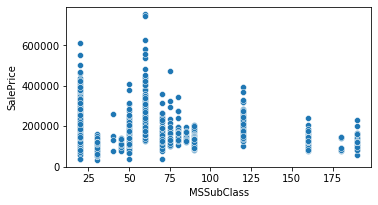

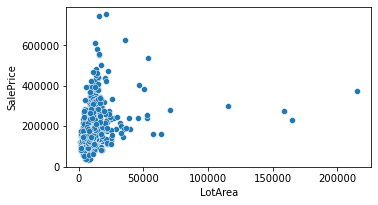

In [5]:
def pltFigure():
    names=['OverallQual','TotalSF','MSSubClass', 'LotArea', ]
    for name in names:
        fig = plt.figure(figsize=(12,10))
        plt.subplot(321)
        sns.scatterplot(data=df, x=name, y="SalePrice")
        plt.show()
pltFigure()

# Linear Regression
R-squared and accuracy produced a 0.7979 performance result:
* The linear regression cross validated is 0.7785.
* Both ridge and lasso regression r-squared result is 0.7785.

Linear regression r2 score:  0.8217
Accuracy:  0.8217
0.7855  linear regression cross validate mean
Ridge Regression R2:  0.7856
Lasso Regression R2:  0.7855


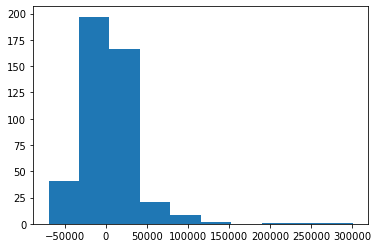

In [6]:
#LINEAR REGRESSION MODEL:
from sklearn.linear_model import LinearRegression, Ridge, Lasso

#Split the data set into training data and test data:
x_train_data, x_test_data, y_train_data, y_test_data = train_test_split(X, y, test_size = 0.3, random_state=42)

lrModel = LinearRegression()
lrModel.fit(x_train_data, y_train_data)
#print(model.coef_)
#print(model.intercept_)

#Generate Predictions:
predictions = lrModel.predict(x_test_data)

# plt.scatter(y_test, predictions)
plt.hist(y_test_data - predictions)

#Performance measurement:
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, r2_score
#print(classification_report(y_test_data, predictions))
#print(confusion_matrix(y_test_data, predictions))

metrics.mean_absolute_error(y_test_data, predictions)
metrics.mean_squared_error(y_test_data, predictions)
np.sqrt(metrics.mean_squared_error(y_test_data, predictions))

#use model to predict probability that given y value is 1:
y_pred_proba = lrModel.predict(x_test_data)
r2 = r2_score(y_test_data, y_pred_proba).round(4) 
print("Linear regression r2 score: ", r2)

#CROSS VALIDATE TEST RESULTS:
lr_score = lrModel.score(x_test_data, y_test_data).round(4)  # train test 
print("Accuracy: ", lr_score)
lr_cv = cross_validate(lrModel, X, y, cv = 5, scoring= 'r2')
lr_cvMean=lr_cv['test_score'].mean().round(4)
print(lr_cvMean, " linear regression cross validate mean")

#RIDGE REGRESSION:
ridge = Ridge(alpha = .5)  # sets alpha to a default value as baseline  
ridge.fit(x_train_data, y_train_data)
ridge_cv = cross_validate(ridge, X, y, cv = 5, scoring = 'r2')
ridge_cvMean=ridge_cv['test_score'].mean().round(4)
print ("Ridge Regression R2: ", ridge_cvMean)

#LASSO REGRESSION:
lasso = Lasso(alpha = .1, normalize=True)  # sets alpha to almost zero as baseline
lasso.fit(x_train_data, y_train_data)
lasso_cv = cross_validate(lasso, X, y, cv = 5, scoring = 'r2')
lasso_cvMean=lasso_cv['test_score'].mean().round(4)
print ("Lasso Regression R2: ", lasso_cvMean)

# Random Forest Prediction:
R-squared for random forest is 0.8905. The results used an n_estimator of 400 which provides the lowest mean absolute error (MAE).

In [7]:
#RANDOM FOREST MODEL:
from sklearn.ensemble import RandomForestRegressor

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 0)

#TEST TO SEE WHAT n_estimators value produces the least amount of MAE error:
dMAE={} #dictionary of n_estimators as key and MAE as value:
def checkMAE():
    for n in range(100, 1401, 100):
        forest = RandomForestRegressor(n_estimators=n, random_state = 0)
        forest.fit(X_train, y_train)
        y_pred = forest.predict(X_test)
        MAE=metrics.mean_absolute_error(y_test, y_pred).round(2)
        dMAE[n]=MAE
        #print("n_estimates: ", n,  '  Mean Absolute Error:', MAE)

    dMAE=sorted(((v, k) for k, v in dMAE.items()), reverse=False)
    #print(dMAE) #[(18573.45, 400), (18632.04, 200), (18636.62, 500), (18644.81, 300), (18651.96, 600),

num=400 #lowest n_estimators in MAE in sorted dic
forest = RandomForestRegressor(n_estimators=num, random_state = 0)
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)
rf_r2 = r2_score(y_test, y_pred).round(4) 
print("Random forest r2: ", rf_r2) #Random forest r2:  0.8905

Random forest r2:  0.8515


# Decision Tree
The decision tree r-sqaured is 0.6948 which is much lower than the other predictive models. More tests will need to be run to verify if the data has been underfit.

In [8]:
#DECISION TREE
from sklearn.tree import DecisionTreeRegressor

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 0)

#FIND best_tree_size LEAF NODES:
def get_mae(max_leaf_nodes, train_X, val_X, train_y, val_y):
    model = DecisionTreeRegressor(max_leaf_nodes=max_leaf_nodes, random_state=42)
    model.fit(train_X, train_y)
    preds_val = model.predict(val_X)
    mae = mean_absolute_error(val_y, preds_val)
    return(mae)

candidate_max_leaf_nodes = [5, 25, 50, 100, 250, 500]
maeDic={} #dictionary  key=leaf  mae=value
for leaf in candidate_max_leaf_nodes:
    mae=get_mae(leaf, X_train, X_test, y_train, y_test)
    maeDic[leaf]=mae

best_tree_size = sorted(maeDic, key=lambda x : maeDic[x])[0]

#MAKE PREDICTION:
tree = DecisionTreeRegressor(max_leaf_nodes=best_tree_size, random_state=42)
tree.fit(X, y)
y_pred = tree.predict(X_test)

tree_r2 = r2_score(y_test, y_pred).round(4)
print("Decision tree r2: ", tree_r2)

def printReports(y_test, y_pred):
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))

Decision tree r2:  0.9276


# Gradient Boost regression and Feature Importance

Gradient boosting regression r-squared is 0.5721, and the mean squared error (MSE) on test set: 0.1063.

Gradient boosting regression r2:  0.878
The mean squared error (MSE) on test set: 814421920.0986


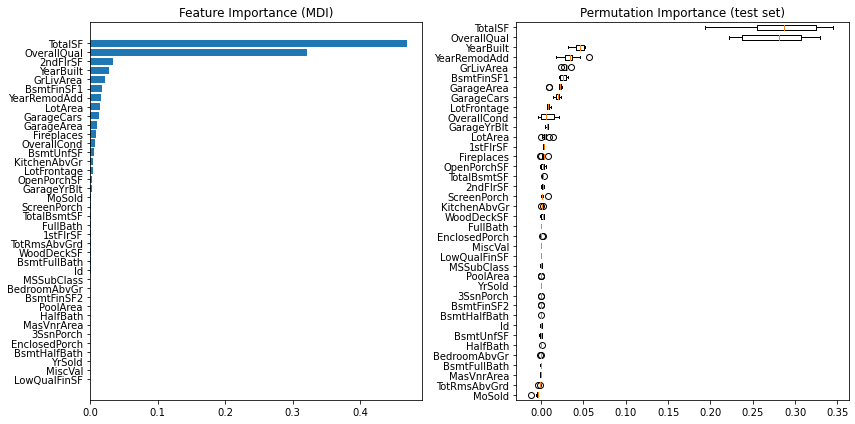

In [9]:
#GRADIENT BOOST REGRESSION:
from sklearn.inspection import permutation_importance
from sklearn.ensemble import GradientBoostingClassifier,GradientBoostingRegressor

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=13)

params = {
 "n_estimators": 500, "max_depth": 4, "min_samples_split": 5, "learning_rate": 0.01,
}

reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)
gbr_r2 = r2_score(y_test, y_pred).round(4) 
print("Gradient boosting regression r2: ", gbr_r2) 

mse = mean_squared_error(y_test, reg.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

#FEATURE IMPORTANCE:
cols=X.columns
feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(cols)[sorted_idx])
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    reg, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(cols)[sorted_idx],
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

# Final House Price Pediction

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.99, random_state=13)
#y_train = df.loc[:,"SalePrice"]

# So, we need to log-transform y to train and exp-transform the predictions:
reg.fit(X_train, np.log(y_train))
predictions = np.exp(reg.predict(X_test))

output = pd.DataFrame({'Id': X_test.index, 'SalePrice': predictions}).sort_values(by='Id').reset_index()
#print(output.shape) #(1446, 2)
print(output.head())
output.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")

   index  Id      SalePrice
0    337   0  187035.859584
1   1438   1  201733.036095
2    909   2  187192.005471
3    219   3  180771.642068
4    199   4  238110.918338
Your submission was successfully saved!


### Helpful Resources:
* https://www.kaggle.com/niekvanderzwaag/housing-price-prediction-regression
* https://www.kaggle.com/ryanholbrook/feature-engineering-for-house-prices
* https://www.kaggle.com/gprakhar579/house-price-prediction-ml#Outlier-detection-in-training-data-set

### Future ideas
* https://machinelearningmastery.com/stacking-ensemble-machine-learning-with-python/